### Channel Estimation with Convolutional Neural Network

### connecting google drive to colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### scipy is used for loading .mat format dataset

In [3]:
import scipy.io

In [4]:
perfect=scipy.io.loadmat('/content/drive/MyDrive/deep_mimo_dataset/Perfect_H_40000.mat')['My_perfect_H']

In [5]:
noisy_input_12=scipy.io.loadmat('/content/drive/MyDrive/deep_mimo_dataset/My_noisy_H_12.mat')

In [6]:
noisy_input=scipy.io.loadmat('/content/drive/MyDrive/deep_mimo_dataset/My_noisy_H_22.mat')['My_noisy_H']

### printing 4d dataset

In [7]:
print(noisy_input)

[[[ 0.11346515+1.78369765e-01j  0.12842974+1.93799422e-01j
    0.10442415+1.11861634e-01j ...  0.01204982+8.60761496e-02j
   -0.05617651-5.52056095e-02j -0.05896273-2.43147194e-02j]
  [ 0.14678281+2.79888491e-01j  0.14603456+1.86929540e-01j
    0.21363323-5.03918705e-02j ... -0.03231674-1.67187478e-02j
   -0.00437249-2.67441413e-02j -0.0443623 -9.01486361e-02j]
  [ 0.13405688+1.92492931e-01j  0.15259018+2.52159722e-01j
    0.08010592+1.26060263e-01j ... -0.01841545-1.23733221e-02j
   -0.10515809+8.16199416e-02j -0.01606184-1.02421556e-01j]
  ...
  [-0.27850168+1.00207728e+00j -0.2195267 +9.78058208e-01j
   -0.30801927+9.58224730e-01j ... -0.56137782+7.59049723e-01j
   -0.57698416+5.52059521e-01j -0.68552004+5.32755628e-01j]
  [-0.12879531+1.16106470e+00j -0.30296394+1.06230184e+00j
   -0.28960861+9.73067927e-01j ... -0.58373902+6.30708142e-01j
   -0.61913178+5.99864725e-01j -0.64946205+5.78328197e-01j]
  [-0.17285247+1.12343024e+00j -0.22100633+1.20303412e+00j
   -0.224948  +9.54911956

### logging information

In [8]:
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s | %(process)d | %(name)s | %(levelname)s:  %(message)s',
                    datefmt='%d/%b/%Y - %H:%M:%S')

logger = logging.getLogger(__name__)
print(logger)


<Logger __main__ (WARNING)>


### Size and shape of the dataset

In [9]:
print(noisy_input.shape)

(40000, 72, 14)


In [10]:
import numpy as np

### Analysis of interpolation

In [11]:
idx = [14 * i for i in range(1, 72, 6)] + [4 + 14 * i for i in range(4, 72, 6)] + \
              [7 + 14 * i for i in range(1, 72, 6)] + [11 + 14 * i for i in range(4, 72, 6)]
print(idx)

[14, 98, 182, 266, 350, 434, 518, 602, 686, 770, 854, 938, 60, 144, 228, 312, 396, 480, 564, 648, 732, 816, 900, 984, 21, 105, 189, 273, 357, 441, 525, 609, 693, 777, 861, 945, 67, 151, 235, 319, 403, 487, 571, 655, 739, 823, 907, 991]


In [12]:
r=[x//14 for x in idx]
c=[x%14 for x in idx]
print(r)
print(c)
q=zip(r,c)
print(set(q))

[1, 7, 13, 19, 25, 31, 37, 43, 49, 55, 61, 67, 4, 10, 16, 22, 28, 34, 40, 46, 52, 58, 64, 70, 1, 7, 13, 19, 25, 31, 37, 43, 49, 55, 61, 67, 4, 10, 16, 22, 28, 34, 40, 46, 52, 58, 64, 70]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
{(34, 4), (64, 11), (37, 0), (67, 7), (58, 4), (22, 11), (61, 0), (19, 0), (43, 0), (1, 0), (25, 7), (16, 4), (46, 11), (49, 7), (40, 4), (7, 7), (64, 4), (31, 7), (67, 0), (22, 4), (55, 7), (70, 11), (28, 11), (4, 11), (52, 11), (25, 0), (10, 11), (46, 4), (49, 0), (13, 7), (7, 0), (31, 0), (55, 0), (70, 4), (34, 11), (37, 7), (28, 4), (4, 4), (58, 11), (61, 7), (52, 4), (19, 7), (10, 4), (13, 0), (43, 7), (1, 7), (40, 11), (16, 11)}


###Import packages

In [13]:
import numpy as np
import math
from keras.models import Sequential,  Model
from keras.layers import Convolution2D,Input,BatchNormalization,Conv2D,Activation,Lambda,Subtract,Conv2DTranspose, PReLU
from keras.regularizers import l2
from keras.layers import  Reshape,Dense,Flatten
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
from scipy.io import loadmat
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
import numpy as np
import math
from scipy import interpolate


### calculating Peak signal to noise ratio

In [14]:
def psnr(target, ref):
    # assume RGB image
    target_data = np.array(target, dtype=float)
    ref_data = np.array(ref, dtype=float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

### Function of interpolation
#### reference: LTE documatation for pilot symbol

In [15]:
def interpolation(noisy , SNR , Number_of_pilot , interp):
    noisy_image = np.zeros((40000,72,14,2))

    noisy_image[:,:,:,0] = np.real(noisy)
    noisy_image[:,:,:,1] = np.imag(noisy)

    idx=[]


    if (Number_of_pilot == 48):
        idx = [14*i for i in range(1, 72,6)]+[4+14*i for i in range(4, 72,6)]+[7+14*i for i in range(1, 72,6)]+[11+14*i for i in range(4, 72,6)]
    elif (Number_of_pilot == 16):
        idx= [4+14*i for i in range(1, 72,9)]+[9+14*i for i in range(4, 72,9)]
    elif (Number_of_pilot == 24):
        idx = [14*i for i in range(1,72,9)]+ [6+14*i for i in range(4,72,9)]+ [11+14*i for i in range(1,72,9)]
    elif (Number_of_pilot == 8):
      idx = [4+14*i for  i in range(5,72,18)]+[9+14*i for i in range(8,72,18)]
    elif (Number_of_pilot == 36):
      idx = [14*i for  i in range(1,72,6)]+[6+14*i for i in range(4,72,6)] + [11+14*i for i in range(1,72,6)]



    r = [x//14 for x in idx]
    c = [x%14 for x in idx]



    interp_noisy = np.zeros((40000,72,14,2))

    for i in range(len(noisy)):
        z = [noisy_image[i,j,k,0] for j,k in zip(r,c)]
        if(interp == 'rbf'):
            f = interpolate.Rbf(np.array(r).astype(float), np.array(c).astype(float), z,function='gaussian')
            X , Y = np.meshgrid(range(72),range(14))
            z_intp = f(X, Y)
            interp_noisy[i,:,:,0] = z_intp.T
        elif(interp == 'spline'):
            tck = interpolate.bisplrep(np.array(r).astype(float), np.array(c).astype(float), z)
            z_intp = interpolate.bisplev(range(72),range(14),tck)
            interp_noisy[i,:,:,0] = z_intp
        z = [noisy_image[i,j,k,1] for j,k in zip(r,c)]
        if(interp == 'rbf'):
            f = interpolate.Rbf(np.array(r).astype(float), np.array(c).astype(float), z,function='gaussian')
            X , Y = np.meshgrid(range(72),range(14))
            z_intp = f(X, Y)
            interp_noisy[i,:,:,1] = z_intp.T
        elif(interp == 'spline'):
            tck = interpolate.bisplrep(np.array(r).astype(float), np.array(c).astype(float), z)
            z_intp = interpolate.bisplev(range(72),range(14),tck)
            interp_noisy[i,:,:,1] = z_intp


    interp_noisy = np.concatenate((interp_noisy[:,:,:,0], interp_noisy[:,:,:,1]), axis=0).reshape(80000, 72, 14, 1)


    return interp_noisy

### Super Resulation Convolution Neural Network (model architecture)

In [16]:
def SRCNN_model():

    input_shape = (72,14,1)
    x = Input(shape = input_shape)
    c1 = Convolution2D( 64 , (9 , 9) , activation = 'relu', padding="same", kernel_initializer="he_normal")(x)
    c2 = Convolution2D( 32 , (1 , 1 ), activation = 'relu', padding="same", kernel_initializer="he_normal")(c1)
    c3 = Convolution2D( 1 , (5 , 5) , padding="same", kernel_initializer="he_normal")(c2)
    #c4 = Input(shape = input_shape)(c3)
    model = Model(inputs = x, outputs = c3)
    ##compile
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

### train model
#### batch size: 128
#### epochs: 20

In [17]:
def SRCNN_train(train_data ,train_label, val_data , val_label , channel_model , num_pilots , SNR ):
    srcnn_model = SRCNN_model()
    print(srcnn_model.summary())

    checkpoint = ModelCheckpoint("SRCNN_check.h5", monitor='val_loss', verbose=1, save_best_only=True,
                                 save_weights_only=False, mode='min')
    callbacks_list = [checkpoint]

    srcnn_model.fit(train_data, train_label, batch_size=128, validation_data=(val_data, val_label),
                    callbacks=callbacks_list, shuffle=True, epochs= 20 , verbose=0)

    #srcnn_model.save_weights("drive/codes/my_srcnn/SRCNN_SUI5_weights/SRCNN_48_12.h5")
    srcnn_model.save_weights("SRCNN_" + channel_model +"_"+ str(num_pilots) + "_"  + str(SNR) + ".h5")

### Predict function for cnn model

In [28]:
def SRCNN_predict(input_data , channel_model , num_pilots , SNR):
    srcnn_model = SRCNN_model()
    #srcnn_model.load_weights("SRCNN_" + channel_model +"_"+ str(num_pilots) + "_"  + str(SNR) + ".h5")
    srcnn_model.load_weights('/content/drive/MyDrive/com_project_output/SRCNN_check.h5')
    predicted  = srcnn_model.predict(input_data)
    return predicted

### model architecture for denoising convolutional neural network

In [19]:
def DNCNN_model ():

    inpt = Input(shape=(None,None,1))
    # 1st layer, Conv+relu
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(inpt)
    x = Activation('relu')(x)
    # 18 layers, Conv+BN+relu
    for i in range(18):
        x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
        x = BatchNormalization(axis=-1, epsilon=1e-3)(x)
        x = Activation('relu')(x)
    # last layer, Conv
    x = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = Subtract()([inpt, x])   # input - noise
    model = Model(inputs=inpt, outputs=x)
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

### DNCNN train function

In [20]:
def DNCNN_train(train_data ,train_label, val_data , val_label, channel_model , num_pilots , SNR ):

  dncnn_model = DNCNN_model()
  print(dncnn_model.summary())

  checkpoint = ModelCheckpoint("DNCNN_check.h5", monitor='val_loss', verbose=1, save_best_only=True,
                               save_weights_only=False, mode='min')
  callbacks_list = [checkpoint]

  dncnn_model.fit(train_data, train_label, batch_size=128, validation_data=(val_data, val_label),
                  callbacks=callbacks_list, shuffle=True, epochs= 5 , verbose=0)
  dncnn_model.save_weights("DNCNN_" + channel_model +"_"+ str(num_pilots) + "_"  + str(SNR) + ".h5")

### DNCNN predict function

In [21]:
def DNCNN_predict(input_data, channel_model , num_pilots , SNR):
  dncnn_model = DNCNN_model()
  dncnn_model.load_weights("DNCNN_" + channel_model +"_"+ str(num_pilots) + "_"  + str(SNR) + ".h5")
  predicted  = dncnn_model.predict(input_data)
  return predicted

### initializing SNR, Number of pilot, Channel_model

In [22]:
SNR = 22
Number_of_pilots = 48
channel_model='VehA'
num_pilots=48

### spliting the data set into 90% train dataset and 10% validation dataset

In [36]:
interp_noisy = interpolation(noisy_input , SNR , Number_of_pilots , 'rbf')

perfect_image = np.zeros((len(perfect),72,14,2))
perfect_image[:,:,:,0] = np.real(perfect)
perfect_image[:,:,:,1] = np.imag(perfect)
perfect_image = np.concatenate((perfect_image[:,:,:,0], perfect_image[:,:,:,1]), axis=0).reshape(2*len(perfect), 72, 14, 1)


idx_random = np.random.rand(len(perfect_image)) < (1/9)  # uses 32000 from 36000 as training and the rest as validation
train_data, train_label = interp_noisy[idx_random,:,:,:] , perfect_image[idx_random,:,:,:]
val_data, val_label = interp_noisy[~idx_random,:,:,:] , perfect_image[~idx_random,:,:,:]



### Training CNN dataset

In [45]:
SRCNN_train(train_data ,train_label, val_data , val_label , channel_model , Number_of_pilots , SNR )

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 72, 14, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 72, 14, 64)        5248      
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 14, 32)        2080      
                                                                 
 conv2d_14 (Conv2D)          (None, 72, 14, 1)         801       
                                                                 
Total params: 8129 (31.75 KB)
Trainable params: 8129 (31.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None

Epoch 1: val_loss improved from inf to 0.00949, saving model to SRCNN_check.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.00949 to 0.00525, saving model to SRCNN_check.h5

Epoch 3: val_loss improved from 0.00525 to 0.00416, saving model to SRCNN_check.h5

Epoch 4: val_loss improved from 0.00416 to 0.00366, saving model to SRCNN_check.h5

Epoch 5: val_loss improved from 0.00366 to 0.00329, saving model to SRCNN_check.h5

Epoch 6: val_loss improved from 0.00329 to 0.00303, saving model to SRCNN_check.h5

Epoch 7: val_loss improved from 0.00303 to 0.00284, saving model to SRCNN_check.h5

Epoch 8: val_loss improved from 0.00284 to 0.00270, saving model to SRCNN_check.h5

Epoch 9: val_loss improved from 0.00270 to 0.00255, saving model to SRCNN_check.h5

Epoch 10: val_loss improved from 0.00255 to 0.00249, saving model to SRCNN_check.h5

Epoch 11: val_loss improved from 0.00249 to 0.00235, saving model to SRCNN_check.h5

Epoch 12: val_loss improved from 0.00235 to 0.00229, saving model to SRCNN_check.h5

Epoch 13: val_loss improved from 0.00229 to 0.00225, saving model to SRC

### shape of the input data for prediction

In [25]:
print(val_data.shape)
print(train_data.shape)
print(val_label.shape)
print(train_label.shape)

(8788, 72, 14, 1)
(71212, 72, 14, 1)
(8788, 72, 14, 1)
(71212, 72, 14, 1)


### prediction for CNN model

In [37]:
srcnn_pred_train = SRCNN_predict(train_data, channel_model , num_pilots , SNR)
#srcnn_pred_validation = SRCNN_predict(val_data, channel_model , num_pilots , SNR)

280/280 [==============================] - 14s 51ms/step


### converting the 4d array into pandas dataframe

In [30]:
import pandas as pd
mesh = pd.DataFrame(np.column_stack(list(map(np.ravel, np.meshgrid(*map(np.arange, srcnn_pred_validation.shape), indexing="ij"))) + [srcnn_pred_validation.ravel()]),
                   columns=["mode", "x", "y", "z", "val"])

val_pred_data_df = pd.DataFrame([index + (x,) for index, x in np.ndenumerate(srcnn_pred_validation)], columns=["mode", "x", "y", "z", "val"])
print(val_pred_data_df)

         mode   x   y  z       val
0           0   0   0  0  0.081844
1           0   0   1  0  0.080660
2           0   0   2  0  0.073292
3           0   0   3  0  0.061574
4           0   0   4  0  0.082314
...       ...  ..  .. ..       ...
8858299  8787  71   9  0 -0.830523
8858300  8787  71  10  0 -0.827849
8858301  8787  71  11  0 -0.777215
8858302  8787  71  12  0 -0.714553
8858303  8787  71  13  0 -0.670813

[8858304 rows x 5 columns]


In [31]:
import pandas as pd
mesh = pd.DataFrame(np.column_stack(list(map(np.ravel, np.meshgrid(*map(np.arange, val_label.shape), indexing="ij"))) + [val_label.ravel()]),
                   columns=["mode", "x", "y", "z", "val"])

val_label_df = pd.DataFrame([index + (x,) for index, x in np.ndenumerate(val_label)], columns=["mode", "x", "y", "z", "val"])
print(val_label_df)

         mode   x   y  z       val
0           0   0   0  0  0.178767
1           0   0   1  0  0.158222
2           0   0   2  0  0.138010
3           0   0   3  0  0.118092
4           0   0   4  0  0.098504
...       ...  ..  .. ..       ...
8858299  8787  71   9  0 -0.822535
8858300  8787  71  10  0 -0.801185
8858301  8787  71  11  0 -0.778274
8858302  8787  71  12  0 -0.753831
8858303  8787  71  13  0 -0.727891

[8858304 rows x 5 columns]


In [38]:
import pandas as pd
mesh = pd.DataFrame(np.column_stack(list(map(np.ravel, np.meshgrid(*map(np.arange, train_label.shape), indexing="ij"))) + [train_label.ravel()]),
                   columns=["mode", "x", "y", "z", "val"])

train_label_df = pd.DataFrame([index + (x,) for index, x in np.ndenumerate(train_label)], columns=["mode", "x", "y", "z", "val"])
print(train_label_df)

         mode   x   y  z       val
0           0   0   0  0  0.733608
1           0   0   1  0  0.721786
2           0   0   2  0  0.709077
3           0   0   3  0  0.695456
4           0   0   4  0  0.680944
...       ...  ..  .. ..       ...
9000427  8928  71   9  0 -1.410350
9000428  8928  71  10  0 -1.411438
9000429  8928  71  11  0 -1.411081
9000430  8928  71  12  0 -1.409281
9000431  8928  71  13  0 -1.406039

[9000432 rows x 5 columns]


In [39]:
import pandas as pd
mesh = pd.DataFrame(np.column_stack(list(map(np.ravel, np.meshgrid(*map(np.arange, srcnn_pred_train.shape), indexing="ij"))) + [srcnn_pred_train.ravel()]),
                   columns=["mode", "x", "y", "z", "val"])

train_pred_data_df = pd.DataFrame([index + (x,) for index, x in np.ndenumerate(srcnn_pred_train)], columns=["mode", "x", "y", "z", "val"])
print(train_pred_data_df)

         mode   x   y  z       val
0           0   0   0  0  0.772469
1           0   0   1  0  0.807863
2           0   0   2  0  0.791140
3           0   0   3  0  0.741748
4           0   0   4  0  0.804725
...       ...  ..  .. ..       ...
9000427  8928  71   9  0 -1.348574
9000428  8928  71  10  0 -1.369928
9000429  8928  71  11  0 -1.349662
9000430  8928  71  12  0 -1.222855
9000431  8928  71  13  0 -1.142452

[9000432 rows x 5 columns]


### Calculating the root mean square error (RMSE) for validation

In [32]:
y_actual=val_label_df['val']
y_hat=val_pred_data_df['val']

In [33]:
MSE = np.square(np.subtract(y_actual,y_hat)).mean()

RMSE = math.sqrt(MSE)

print(RMSE)

0.044470220616021336


### calculating the min absolute percentage error(MAPE) for validation

In [34]:
mape = np.mean(np.abs((y_actual - y_hat)/y_actual))*100
print(mape)

61.68636471650335


In [35]:
print(psnr(y_hat,y_actual))

75.16941792904018


### Calculating the root mean square error (RMSE) for validation

In [40]:
y_actual=train_label_df['val']
y_hat=train_pred_data_df['val']

In [41]:
MSE = np.square(np.subtract(y_actual,y_hat)).mean()

RMSE = math.sqrt(MSE)

print(RMSE)

0.04455599378509171


### calculating the min absolute percentage error(MAPE) for validation

In [42]:
mape = np.mean(np.abs((y_actual - y_hat)/y_actual))*100
print(mape)

63.66284361112869


### ploting the whole dataset in matplotlib

In [ ]:
import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:4411: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)
/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:551: ComplexWarning: Casting complex values to real discards the imaginary part
  (np.asanyarray(self.convert_xunits(offsets[:, 0]), float),
/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:552: ComplexWarning: Casting complex values to real discards the imaginary part
  np.asanyarray(self.convert_yunits(offsets[:, 1]), float)))
/usr/local/lib/python3.10/dist-packa

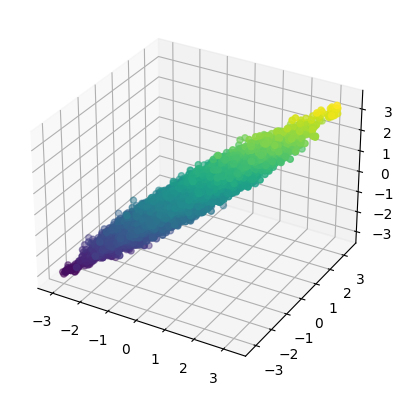

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = noisy_input[:, 0]
y = noisy_input[:, 1]
z = noisy_input[:, 2]
ax.scatter(x, y, z, c=z)

plt.show()

### DNCNN train, validation and converting it to pandas dataframe

In [ ]:
DNCNN_train(train_data ,train_label, val_data , val_label , channel_model , Number_of_pilots , SNR )

In [ ]:
DNcnn_pred_train = DNCNN_predict(train_data, channel_model , num_pilots , SNR)
DNcnn_pred_validation = DNCNN_predict(val_data, channel_model , num_pilots , SNR)

In [ ]:
mesh = pd.DataFrame(np.column_stack(list(map(np.ravel, np.meshgrid(*map(np.arange, train_data.shape), indexing="ij"))) + [train_data.ravel()]),
                   columns=["mode", "x", "y", "z", "val"])

train_data_df = pd.DataFrame([index + (x,) for index, x in np.ndenumerate(train_data)], columns=["mode", "x", "y", "z", "val"])
print(train_data_df)

In [ ]:
train_data_path='/content/drive/MyDrive/com_project_output/train_data.xlsx'
df=pd.read_csv(train_data_path)

In [ ]:
df

,Unnamed: 0,mode,x,y,z,val
0,0,0,0,0,0,-0.175454
1,1,0,0,1,0,-0.146027
2,2,0,0,2,0,-0.149835
3,3,0,0,3,0,-0.151047
4,4,0,0,4,0,-0.170183
...,...,...,...,...,...,...
9045787,9045787,8973,71,9,0,0.181830
9045788,9045788,8973,71,10,0,0.201224
9045789,9045789,8973,71,11,0,0.161550
9045790,9045790,8973,71,12,0,0.133045


In [ ]:
import pandas as pd

In [ ]:
srcnn_pred_train_data_path='/content/drive/MyDrive/com_project_output/srcnn_pred_train.csv'
train_pred_df=pd.read_csv(srcnn_pred_train_data_path)

In [ ]:
print(train_pred_df)

         Unnamed: 0  mode   x   y  z       val
0                 0     0   0   0  0  0.772469
1                 1     0   0   1  0  0.807863
2                 2     0   0   2  0  0.791140
3                 3     0   0   3  0  0.741748
4                 4     0   0   4  0  0.804724
...             ...   ...  ..  .. ..       ...
9107275     9107275  9034  71   9  0 -1.534900
9107276     9107276  9034  71  10  0 -1.551719
9107277     9107277  9034  71  11  0 -1.473691
9107278     9107278  9034  71  12  0 -1.348018
9107279     9107279  9034  71  13  0 -1.222418

[9107280 rows x 6 columns]


In [ ]:
val_data_path='/content/drive/MyDrive/com_project_output/val_data.csv'
val_df=pd.read_csv(val_data_path)
print(val_df)

         Unnamed: 0  mode   x   y  z       val
0                 0     0   0   0  0  0.718846
1                 1     0   0   1  0  0.726909
2                 2     0   0   2  0  0.686918
3                 3     0   0   3  0  0.629846
4                 4     0   0   4  0  0.583760
...             ...   ...  ..  .. ..       ...
9029659     9029659  8957  71   9  0 -1.208934
9029660     9029660  8957  71  10  0 -1.234805
9029661     9029661  8957  71  11  0 -1.199754
9029662     9029662  8957  71  12  0 -1.072215
9029663     9029663  8957  71  13  0 -0.863861

[9029664 rows x 6 columns]


In [ ]:
val_pred_data_path='/content/drive/MyDrive/com_project_output/srcnn_pred_validation.csv'
val_pred_df=pd.read_csv(val_pred_data_path)
print(val_pred_df)

         Unnamed: 0  mode   x   y  z       val
0                 0     0   0   0  0  0.772469
1                 1     0   0   1  0  0.807863
2                 2     0   0   2  0  0.791140
3                 3     0   0   3  0  0.741748
4                 4     0   0   4  0  0.804724
...             ...   ...  ..  .. ..       ...
9029659     9029659  8957  71   9  0 -1.534900
9029660     9029660  8957  71  10  0 -1.551719
9029661     9029661  8957  71  11  0 -1.473691
9029662     9029662  8957  71  12  0 -1.348018
9029663     9029663  8957  71  13  0 -1.222418

[9029664 rows x 6 columns]


In [ ]:
import matplotlib.pyplot as plt


### plotting the actual vs predicted data

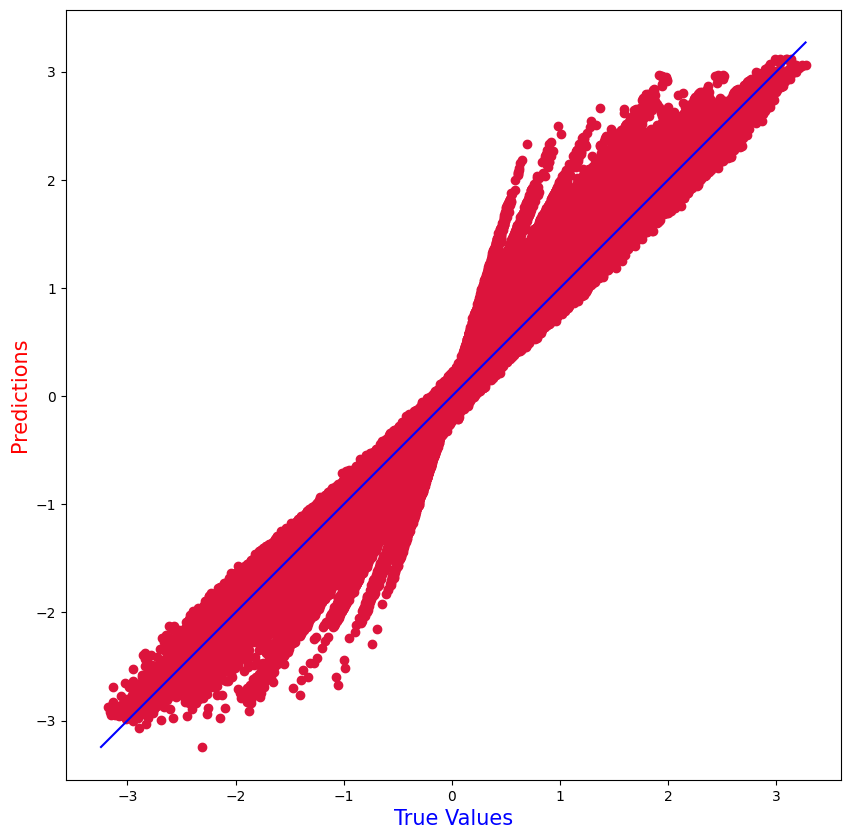

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_actual, y_hat, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_hat), max(y_actual))
p2 = min(min(y_hat), min(y_actual))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', color='blue',fontsize=15)
plt.ylabel('Predictions', color='red',fontsize=15)
plt.axis('equal')
plt.show()

### red indicates the auctual input validation data
### blue indicates the predicted validation data

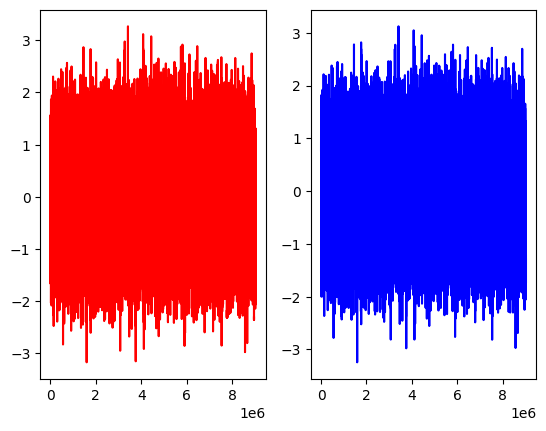

In [ ]:
plt.subplot(1,2,1)
plt.plot(x,y_actual,color='red')
plt.subplot(1,2,2)
plt.plot(x,y_hat,color='blue')